## Oil & Gas Biodiversity Screening (GBIF)

Independent notebook for a **TNFD-style screening** using GBIF occurrence data + asset locations.

What you get:
- Download + cache GBIF occurrences for a city + surroundings
- Clean analysis table
- Asset proximity metrics (records, richness) by distance bands
- Simple sensitivity ranking proxy

**Note**: This is a screening workflow, not a full EIA.


In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

from pygbif import occurrences

import matplotlib.pyplot as plt
import seaborn as sns

# Optional: for quick point maps
import geopandas as gpd

# City -> coordinates
from geopy.geocoders import Nominatim

# Progress bars for paginated API calls
from tqdm.auto import tqdm

# Cluster OSM features into "facilities" (to avoid thousands of storage tanks being treated as separate assets)
from sklearn.cluster import DBSCAN

# Download real-world asset points from OpenStreetMap (Overpass API)
import requests

# Interactive basemap
import folium
from folium.plugins import HeatMap, MarkerCluster

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

sns.set_theme(style="whitegrid")


### 1) Query configuration (City + radius + optional taxon)

We’ll query GBIF occurrences using:
- **CITY** + **RADIUS_KM** → we convert this into a bounding box (min/max lat/lon)
- **TAXON_KEY** (optional) → e.g. `6` means *Plantae*. Set to `None` to fetch **all species**.


In [3]:
# Example: Madrid + surroundings
CITY = "Madrid, Spain"
RADIUS_KM = 30

# Optional filter. Set to None to get all taxa/species.
TAXON_KEY = None  # e.g. 6 for Plantae

# How many records you want to download (GBIF API is paginated)
MAX_RECORDS = 2000
PAGE_SIZE = 300  # GBIF max page size is typically 300

CACHE_DIR = Path("data")
CACHE_DIR.mkdir(exist_ok=True)

# Cache filename is derived from query params
# NOTE: We use JSON Lines (gzipped) for caching to avoid Parquet/Arrow issues in some environments.
safe_city = CITY.lower().replace(",", "").replace(" ", "_")
CACHE_PATH = CACHE_DIR / f"gbif_occurrences_{safe_city}_r{RADIUS_KM}km_taxon{TAXON_KEY}_max{MAX_RECORDS}.jsonl.gz"

CACHE_PATH

PosixPath('data/gbif_occurrences_madrid_spain_r30km_taxonNone_max2000.jsonl.gz')

### 2) What is `pygbif`?

`pygbif` is a Python library that acts as a **thin wrapper around the GBIF API**.

- **GBIF** publishes open biodiversity data: mostly **occurrence records** (who/what, where, when) + lots of metadata.
- `pygbif` lets you query that API from Python without manually writing HTTP requests and parsing JSON.

In this notebook the key call is:
- `occurrences.search(...)`: downloads a page of occurrences (JSON) that we convert into a `pandas.DataFrame`.

Practical caveats:
- It’s an API → can be slow, paginated, and sometimes rate-limited.
- Fields are messy/optional → many missing values, inconsistent date formats, etc.


In [4]:
def geocode_city(city: str) -> tuple[float, float]:
    """Return (lat, lon) for a city name using OpenStreetMap Nominatim."""
    geolocator = Nominatim(user_agent="gbif_eda")
    location = geolocator.geocode(city)
    if location is None:
        raise ValueError(f"Could not geocode city: {city!r}")
    return float(location.latitude), float(location.longitude)


def bbox_from_city(city: str, radius_km: float) -> dict:
    """Approximate bounding box around a city center.

    Uses a simple conversion:
    - 1 degree latitude ~ 111 km
    - 1 degree longitude ~ 111 km * cos(latitude)

    Good enough for an EDA demo.
    """
    lat, lon = geocode_city(city)
    lat_delta = radius_km / 111.0
    lon_delta = radius_km / (111.0 * np.cos(np.deg2rad(lat)))
    return {
        "min_lat": lat - lat_delta,
        "max_lat": lat + lat_delta,
        "min_lon": lon - lon_delta,
        "max_lon": lon + lon_delta,
        "center_lat": lat,
        "center_lon": lon,
    }


def fetch_gbif_occurrences_paged(
    bbox: dict,
    taxon_key: int | None,
    max_records: int = 1000,
    page_size: int = 300,
) -> pd.DataFrame:
    """Fetch GBIF occurrences with pagination.

    - bbox: dict with min/max lat/lon
    - taxon_key: optional. If None, fetch all taxa.
    """
    all_results: list[dict] = []
    offset = 0

    with tqdm(total=max_records, desc="Downloading GBIF occurrences") as pbar:
        while offset < max_records:
            limit = min(page_size, max_records - offset)

            kwargs = dict(
                decimalLatitude=f"{bbox['min_lat']},{bbox['max_lat']}",
                decimalLongitude=f"{bbox['min_lon']},{bbox['max_lon']}",
                hasCoordinate=True,
                limit=limit,
                offset=offset,
            )
            if taxon_key is not None:
                kwargs["taxonKey"] = taxon_key

            resp = occurrences.search(**kwargs)
            results = resp.get("results", [])
            if not results:
                break

            all_results.extend(results)
            offset += len(results)
            pbar.update(len(results))

            # If GBIF returns fewer results than requested, we reached the end.
            if len(results) < limit:
                break

    return pd.DataFrame(all_results)


def _read_cache_jsonl_gz(path: Path) -> pd.DataFrame:
    return pd.read_json(path, orient="records", lines=True, compression="infer")


def _write_cache_jsonl_gz(df: pd.DataFrame, path: Path) -> None:
    df.to_json(path, orient="records", lines=True, compression="infer")


def load_or_fetch(cache_path: Path, bbox: dict) -> pd.DataFrame:
    if cache_path.exists():
        return _read_cache_jsonl_gz(cache_path)

    df_raw = fetch_gbif_occurrences_paged(
        bbox=bbox,
        taxon_key=TAXON_KEY,
        max_records=MAX_RECORDS,
        page_size=PAGE_SIZE,
    )
    _write_cache_jsonl_gz(df_raw, cache_path)
    return df_raw


BBOX = bbox_from_city(CITY, RADIUS_KM)
BBOX


{'min_lat': 40.146511729729724,
 'max_lat': 40.68705227027027,
 'min_lon': np.float64(-4.058495932977153),
 'max_lon': np.float64(-3.3485180670228476),
 'center_lat': 40.416782,
 'center_lon': -3.703507}

### 3) Download + cache occurrences for the selected city

We cache the raw GBIF response to a **compressed JSON Lines** file (`.jsonl.gz`) so you don’t hit the API on every rerun.

If you change `CITY`, `RADIUS_KM`, `TAXON_KEY`, or `MAX_RECORDS`, a different cache file will be used.


In [5]:
df_raw = load_or_fetch(CACHE_PATH, BBOX)

print("City:", CITY)
print("Radius (km):", RADIUS_KM)
print("Taxon key:", TAXON_KEY)
print("Requested max records:", MAX_RECORDS)
print("Downloaded records:", len(df_raw))

df_raw.head(3)

City: Madrid, Spain
Radius (km): 30
Taxon key: None
Requested max records: 2000
Downloaded records: 2000


,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,extensions,basisOfRecord,occurrenceStatus,classifications,taxonKey,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,speciesKey,acceptedTaxonKey,scientificName,scientificNameAuthorship,acceptedScientificName,kingdom,phylum,order,family,genus,species,genericName,specificEpithet,taxonRank,taxonomicStatus,iucnRedListCategory,dateIdentified,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,continent,stateProvince,gadm,year,month,day,eventDate,startDayOfYear,endDayOfYear,issues,modified,lastInterpreted,references,license,isSequenced,identifiers,media,facts,relations,isInCluster,datasetName,recordedBy,identifiedBy,dnaSequenceID,geodeticDatum,class,countryCode,recordedByIDs,identifiedByIDs,gbifRegion,country,publishedByGbifRegion,rightsHolder,identifier,http://unknown.org/nick,verbatimEventDate,gbifID,verbatimLocality,collectionCode,occurrenceID,taxonID,http://unknown.org/captive_cultivated,catalogNumber,institutionCode,eventTime,identificationID,dynamicProperties,vitality,projectId,occurrenceRemarks,lifeStage,informationWithheld,sex,infraspecificEpithet,reproductiveCondition,identificationRemarks,recordNumber,scientificNameID,identificationVerificationStatus,taxonRemarks,vernacularName,http://unknown.org/taxonRankID,taxonConceptID,http://unknown.org/species,individualCount,samplingProtocol,habitat,locality,distanceFromCentroidInMeters,eventID
0,5938028331,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2026-01-08T02:05:14.848+00:00,2026-01-08T22:26:41.313+00:00,575,{'http://rs.gbif.org/terms/1.0/Multimedia': [{...,HUMAN_OBSERVATION,PRESENT,{'7ddf754f-d193-4cc9-b351-99906754a03b': {'usa...,2492956.0,1.0,44.0,212.0,729.0,5285.0,2492941.0,2492956.0,2492956.0,"Sylvia atricapilla (Linnaeus, 1758)","(Linnaeus, 1758)","Sylvia atricapilla (Linnaeus, 1758)",Animalia,Chordata,Passeriformes,Sylviidae,Sylvia,Sylvia atricapilla,Sylvia,atricapilla,SPECIES,ACCEPTED,LC,2026-01-03T15:27:44,40.461052,-3.606193,1.0,EUROPE,Comunidad de Madrid,"{'level0': {'gid': 'ESP', 'name': 'Spain'}, 'l...",2026,1,3,2026-01-03T13:43,3,3,"[COORDINATE_ROUNDED, CONTINENT_DERIVED_FROM_CO...",2026-01-03 15:34:36+00:00,2026-01-08T22:26:41.313+00:00,https://www.inaturalist.org/observations/33330...,http://creativecommons.org/licenses/by-nc/4.0/...,False,[{'identifier': '333301770'}],"[{'type': 'StillImage', 'format': 'image/jpeg'...",[],[],False,iNaturalist research-grade observations,Sergio Ibarra,Sergio Ibarra,[],WGS84,Aves,ES,[],[],EUROPE,Spain,NORTH_AMERICA,Sergio Ibarra,333301770,sergio_ibarra_mellado,2026/01/03 1:43 PM,5938028331,"Corralejos, Barajas, 28042 Madrid, Spain",Observations,https://www.inaturalist.org/observations/33330...,15282.0,wild,333301770.0,iNaturalist,13:43:00+01:00,745977322.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5938028504,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2026-01-08T02:05:14.848+00:00,2026-01-08T23:30:21.263+00:00,575,{'http://rs.gbif.org/terms/1.0/Multimedia': [{...,HUMAN_OBSERVATION,PRESENT,{'7ddf754f-d193-4cc9-b351-99906754a03b': {'usa...,2498344.0,1.0,44.0,212.0,1108.0,2986.0,8996942.0,2498344.0,2498344.0,"Cygnus atratus (Latham, 1790)","(Latham, 1790)","Cygnus atratus (Latham, 1790)",Animalia,Chordata,Anseriformes,Anatidae,Cygnus,Cygnus atratus,Cygnus,atratus,SPECIES,ACCEPTED,LC,2026-01-03T15:13:04,40.413533,-3.681392,NaN,EUROPE,Comunidad de Madrid,"{'level0': {'gid': 'ESP', 'name': 'Spain'}, 'l...",2026,1,3,2026-01-03T12:20:59,3,3,"[CONTINENT_DERIVED_FROM_COORDINATES, TAXON_ID_...",2026-01-03 21:45:58+00:00,2026-01-08T23:30:21.263+00:00,https://www.inaturalist.org/observations/33330...,http:/

### 4) Build a clean analysis table

GBIF records contain many fields and many missing values. For EDA we usually keep a **small, consistent subset**.

Below we:
- select common columns if present
- normalize `eventDate`
- ensure coordinates are numeric
- create helper columns like `event_year` and `event_month`


In [6]:
def pick_existing_columns(df: pd.DataFrame, cols: list[str]) -> list[str]:
    return [c for c in cols if c in df.columns]


CANDIDATE_COLS = [
    "key",
    "occurrenceID",
    "datasetKey",
    "publishingOrgKey",
    "institutionCode",
    "collectionCode",
    "basisOfRecord",
    "occurrenceStatus",
    "scientificName",
    "species",
    "genus",
    "family",
    "order",
    "class",
    "phylum",
    "kingdom",
    "taxonKey",
    "speciesKey",
    "decimalLatitude",
    "decimalLongitude",
    "coordinateUncertaintyInMeters",
    "country",
    "countryCode",
    "stateProvince",
    "municipality",
    "locality",
    "eventDate",
    "year",
    "month",
    "day",
    "recordedBy",
    "identifiedBy",
]

cols = pick_existing_columns(df_raw, CANDIDATE_COLS)
df = df_raw[cols].copy()

# Parse eventDate if present
if "eventDate" in df.columns:
    df["eventDate"] = pd.to_datetime(df["eventDate"], errors="coerce", utc=True)

# Force coordinates to numeric
for c in ["decimalLatitude", "decimalLongitude", "coordinateUncertaintyInMeters"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Helper time columns
if "eventDate" in df.columns:
    df["event_year"] = df["eventDate"].dt.year
    df["event_month"] = df["eventDate"].dt.to_period("M").astype(str)

df.shape

/var/folders/7t/yrpkmv3n0vj6ml2djk_2bdk80000gn/T/ipykernel_5039/148246204.py:55: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["event_month"] = df["eventDate"].dt.to_period("M").astype(str)


(2000, 33)

### 5) Quick overview

These cells answer basic questions:
- How many records and columns do we have?
- What are the dtypes?
- How many unique species are present (in this downloaded sample)?


In [7]:
display(df.head(5))

print("Columns:", len(df.columns))
print("Records:", len(df))

if "species" in df.columns:
    print("Unique species:", df["species"].nunique(dropna=True))

df.dtypes

,key,occurrenceID,datasetKey,publishingOrgKey,institutionCode,collectionCode,basisOfRecord,occurrenceStatus,scientificName,species,genus,family,order,class,phylum,kingdom,taxonKey,speciesKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,country,countryCode,stateProvince,locality,eventDate,year,month,day,recordedBy,identifiedBy,event_year,event_month
0,5938028331,https://www.inaturalist.org/observations/33330...,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,PRESENT,"Sylvia atricapilla (Linnaeus, 1758)",Sylvia atricapilla,Sylvia,Sylviidae,Passeriformes,Aves,Chordata,Animalia,2492956.0,2492956.0,40.461052,-3.606193,1.0,Spain,ES,Comunidad de Madrid,NaN,2026-01-03 13:43:00+00:00,2026,1,3,Sergio Ibarra,Sergio Ibarra,2026.0,2026-01
1,5938028504,https://www.inaturalist.org/observations/33330...,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,PRESENT,"Cygnus atratus (Latham, 1790)",Cygnus atratus,Cygnus,Anatidae,Anseriformes,Aves,Chordata,Animalia,2498344.0,2498344.0,40.413533,-3.681392,NaN,Spain,ES,Comunidad de Madrid,NaN,NaT,2026,1,3,mr_ma89,mr_ma89,NaN,NaN
2,5938029310,https://www.inaturalist.org/observations/33302...,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,PRESENT,"Phoenicurus ochruros (S.G.Gmelin, 1774)",Phoenicurus ochruros,Phoenicurus,Muscicapidae,Passeriformes,Aves,Chordata,Animalia,5739315.0,5739315.0,40.563150,-3.636328,2.0,Spain,ES,Comunidad de Madrid,NaN,2026-01-01 13:23:00+00:00,2026,1,1,San Juan,San Juan,2026.0,2026-01
3,5938030206,https://www.inaturalist.org/observations/33329...,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,PRESENT,"Passer domesticus (Linnaeus, 1758)",Passer domesticus,Passer,Passeridae,Passeriformes,Aves,Chordata,Animalia,5231190.0,5231190.0,40.416325,-3.694387,29.0,Spain,ES,Comunidad de Madrid,NaN,NaT,2026,1,3,greg012345,greg012345,NaN,NaN
4,5938031858,https://www.inaturalist.org/observations/33341...,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,PRESENT,"Linaria cannabina (Linnaeus, 1758)",Linaria cannabina,Linaria,Fringillidae,Passeriformes,Aves,Chordata,Animalia,8104397.0,8104397.0,40.411595,-3.489913,425.0,Spain,ES,Comunidad de Madrid,NaN,2026-01-03 13:00:00+00:00,2026,1,3,Manuel Torvisco Najarro,Manuel Torvisco Najarro,2026.0,2026-01


Columns: 33
Records: 2000
Unique species: 341


key                                            int64
occurrenceID                                     str
datasetKey                                       str
publishingOrgKey                                 str
institutionCode                                  str
collectionCode                                   str
basisOfRecord                                    str
occurrenceStatus                                 str
scientificName                                   str
species                                          str
genus                                            str
family                                           str
order                                            str
class                                            str
phylum                                           str
kingdom                                          str
taxonKey                                     float64
speciesKey                                   float64
decimalLatitude                              f

## 12) Example use case: screening biodiversity sensitivity / potential impact for an oil & gas asset

This is a **screening workflow** (not a full impact assessment).

**Goal**: given an asset location (e.g., refinery, terminal, pipeline segment), use GBIF occurrences near the asset to compute simple proxies:
- proximity-based **records** and **species richness**
- results under **quality filters** (e.g., coordinate uncertainty)
- **time windows** to see whether the surrounding observations are changing

**Key limitations** (important):
- GBIF is **presence-only** (no absences) and strongly affected by sampling effort.
- “More records” often means “more observers”, not necessarily “more biodiversity”.
- Taxonomy can contain synonyms/misidentifications.

Still, it’s very useful for:
- early-stage **site screening** / comparative ranking of candidate sites
- identifying which assets sit near **biodiversity hotspots** (proxy)
- prioritizing where to do deeper studies (field surveys, EIA)


### 12.1 Provide asset locations (replace with your real assets)

You have two options:

- **Option A (recommended for demos): download real-world points from OpenStreetMap (OSM)** using the Overpass API.
  - This is convenient, but OSM tagging is community-driven and can be incomplete.
- **Option B:** provide your own internal asset coordinates (preferred for real assessments).

For a pipeline, you’d typically represent it as many points (or a line geometry if you later use GIS tooling).


In [8]:
USE_OSM_ASSETS = True

# Overpass endpoint (public service; for heavy use, host your own or be polite)
OVERPASS_URL = "https://overpass-api.de/api/interpreter"

# Cache OSM raw features
ASSET_CACHE_PATH = CACHE_DIR / f"osm_assets_{safe_city}_r{RADIUS_KM}km.json"

# IMPORTANT:
# Overpass often returns MANY individual OSM features (e.g., every single storage tank).
# If we treat each feature as a separate "asset", then `nearest_asset_id` will have hundreds/thousands
# of unique values and plots become unreadable.
#
# Solution: cluster nearby OSM features into "facilities".
CLUSTER_OSM_FEATURES = True
ASSET_CLUSTER_KM = 1.0
MAX_FACILITIES = 30  # set to None to keep all facilities

# A pragmatic set of OSM tag queries that often capture refineries/terminals.
# OSM tagging varies a lot; feel free to tweak.
# OSM tagging is community-driven, and `man_made=storage_tank` is VERY generic
# (could be water, chemicals, etc.).
#
# For oil & gas screening we usually:
# - always include refineries
# - optionally include storage tanks ONLY if they look oil-related (e.g. substance/content=oil)
INCLUDE_STORAGE_TANKS = True

OSM_ASSET_QUERIES = [
    # Refineries
    {"industrial": "oil_refinery"},
    {"industrial": "refinery"},
    {"industrial": "petroleum"},
    # Terminals / oil industry areas (sometimes used for depots)
    {"industrial": "oil"},
]

if INCLUDE_STORAGE_TANKS:
    # More specific than a bare `storage_tank`:
    # only keep tanks tagged as oil-related.
    OSM_ASSET_QUERIES += [
        {"man_made": "storage_tank", "substance": "oil"},
        {"man_made": "storage_tank", "content": "oil"},
    ]


def _overpass_tag_selector(tags: dict) -> str:
    # Overpass selector like: [k="v"][k2="v2"]...
    return "".join([f"[{k}={v!r}]".replace("'", '"') for k, v in tags.items()])


def fetch_osm_assets_overpass(bbox: dict, queries: list[dict]) -> list[dict]:
    """Fetch OSM elements matching any of the provided tag dicts within bbox.

    Returns a list of dicts with: osm_type, osm_id, name, asset_type, lat, lon, tags.
    """
    south, west, north, east = bbox["min_lat"], bbox["min_lon"], bbox["max_lat"], bbox["max_lon"]

    blocks = []
    for q in queries:
        sel = _overpass_tag_selector(q)
        blocks.append(f"nwr{sel}({south},{west},{north},{east});")

    overpass_ql = """
    [out:json][timeout:60];
    (
      {blocks}
    );
    out tags center;
    """.format(blocks="\n      ".join(blocks))

    r = requests.post(
        OVERPASS_URL,
        data=overpass_ql.encode("utf-8"),
        headers={"Content-Type": "text/plain"},
        timeout=120,
    )
    r.raise_for_status()
    data = r.json()

    assets = []
    for el in data.get("elements", []):
        tags = el.get("tags", {}) or {}
        name = tags.get("name") or tags.get("operator") or tags.get("brand")

        # Coordinates
        if el.get("type") == "node":
            lat, lon = el.get("lat"), el.get("lon")
        else:
            center = el.get("center") or {}
            lat, lon = center.get("lat"), center.get("lon")

        if lat is None or lon is None:
            continue

        asset_type = tags.get("industrial") or tags.get("man_made") or tags.get("landuse") or "unknown"

        assets.append(
            {
                "osm_type": el.get("type"),
                "osm_id": el.get("id"),
                "name": name,
                "asset_type": asset_type,
                "lat": float(lat),
                "lon": float(lon),
                "tags": tags,
            }
        )

    # Deduplicate by (type,id)
    seen = set()
    unique = []
    for a in assets:
        k = (a["osm_type"], a["osm_id"])
        if k in seen:
            continue
        seen.add(k)
        unique.append(a)

    return unique


def load_or_fetch_osm_assets() -> pd.DataFrame:
    if ASSET_CACHE_PATH.exists():
        return pd.read_json(ASSET_CACHE_PATH)

    raw_list = fetch_osm_assets_overpass(BBOX, OSM_ASSET_QUERIES)
    raw = pd.DataFrame(raw_list)
    raw.to_json(ASSET_CACHE_PATH, orient="records", indent=2)
    return raw


def cluster_osm_assets_to_facilities(osm_assets: pd.DataFrame, cluster_km: float) -> pd.DataFrame:
    """Cluster OSM features into facilities using DBSCAN (haversine distance)."""
    df = osm_assets.dropna(subset=["lat", "lon"]).copy()
    if len(df) == 0:
        return pd.DataFrame(columns=["asset_id", "asset_type", "name", "lat", "lon", "n_osm_features"])

    coords = np.deg2rad(df[["lat", "lon"]].to_numpy())
    eps = cluster_km / 6371.0088  # km -> radians
    labels = DBSCAN(eps=eps, min_samples=1, metric="haversine").fit_predict(coords)
    df["facility_cluster"] = labels

    def pick_name(s: pd.Series):
        s = s.dropna().astype(str)
        s = s[s.str.strip() != ""]
        return s.value_counts().idxmax() if len(s) else None

    def pick_type(s: pd.Series):
        s = s.dropna().astype(str)
        if (s == "oil_refinery").any():
            return "oil_refinery"
        if (s == "refinery").any():
            return "refinery"
        return s.value_counts().idxmax() if len(s) else "unknown"

    facilities = (
        df.groupby("facility_cluster")
        .agg(
            lat=("lat", "mean"),
            lon=("lon", "mean"),
            name=("name", pick_name),
            asset_type=("asset_type", pick_type),
            n_osm_features=("osm_id", "count"),
        )
        .reset_index()
    )

    facilities["asset_id"] = facilities.apply(
        lambda r: f"FAC_{r['asset_type']}_{int(r['facility_cluster'])}", axis=1
    )

    facilities = facilities.sort_values("n_osm_features", ascending=False)
    return facilities[["asset_id", "asset_type", "name", "lat", "lon", "n_osm_features"]]


# Manual fallback (replace with your internal asset list)
manual_assets = pd.DataFrame(
    [
        {"asset_id": "ASSET_001", "asset_type": "refinery_or_terminal", "name": "Manual asset 1", "lat": 40.4168, "lon": -3.7035},
        {"asset_id": "ASSET_002", "asset_type": "refinery_or_terminal", "name": "Manual asset 2", "lat": 40.3500, "lon": -3.8000},
    ]
)

if USE_OSM_ASSETS:
    osm_assets_raw = load_or_fetch_osm_assets()
    if len(osm_assets_raw) == 0:
        print("No OSM assets found for these tags/bbox. Falling back to manual examples.")
        USE_OSM_ASSETS = False

if USE_OSM_ASSETS:
    print("OSM features downloaded:", len(osm_assets_raw))

    if CLUSTER_OSM_FEATURES:
        facilities = cluster_osm_assets_to_facilities(osm_assets_raw, ASSET_CLUSTER_KM)
        print("Facilities after clustering:", len(facilities))

        if MAX_FACILITIES is not None and len(facilities) > MAX_FACILITIES:
            facilities = facilities.head(MAX_FACILITIES).copy()
            print("Keeping top facilities:", len(facilities), "(set MAX_FACILITIES=None for all)")

        assets = facilities
    else:
        # WARNING: can be huge (every tank becomes an asset)
        assets = osm_assets_raw.copy()
        assets["asset_id"] = assets.apply(
            lambda r: f"OSM_{r.get('asset_type','asset')}_{r.get('osm_type')}_{int(r.get('osm_id'))}", axis=1
        )
        assets = assets[["asset_id", "asset_type", "name", "lat", "lon"]]
else:
    assets = manual_assets

# Filter: keep only assets with a non-empty name (requested)
FILTER_TO_NAMED_ASSETS = True

_assets_before = assets.copy()
if FILTER_TO_NAMED_ASSETS and "name" in assets.columns:
    name_clean = assets["name"].astype("string").fillna("").str.strip()
    assets = assets[name_clean != ""].copy()

    if len(assets) == 0:
        print("WARNING: Name filter removed all assets. Keeping the unfiltered set.")
        assets = _assets_before

# Critical: reset index so positional indexing is safe later
assets = assets.reset_index(drop=True)

print("Assets used in analysis:", len(assets))
assets

OSM features downloaded: 308
Facilities after clustering: 93
Keeping top facilities: 30 (set MAX_FACILITIES=None for all)
Assets used in analysis: 4


,asset_id,asset_type,name,lat,lon,n_osm_features
0,FAC_storage_tank_7,storage_tank,Planta de transporte y almacenamiento de produ...,40.470376,-3.575900,14
1,FAC_storage_tank_5,storage_tank,Comunidad de Madrid,40.453050,-3.868989,5
2,FAC_storage_tank_34,storage_tank,Pozo PM-3,40.463119,-3.851810,3
3,FAC_storage_tank_67,storage_tank,Canal de Isabel II,40.248366,-3.757559,3


### 12.2 Prepare a “high quality” occurrence table

A common filter for proximity analysis:
- require valid coordinates
- optionally require `coordinateUncertaintyInMeters <= X`
- optionally focus on recent years


In [12]:
MAX_UNCERTAINTY_M = 1000  # try 100, 1000, 5000 depending on your use case
RECENT_YEARS = 5          # set to None to keep all years

occ = df.copy()

# Require coordinates
occ = occ.dropna(subset=["decimalLatitude", "decimalLongitude"]).copy()

# Optional: filter by uncertainty
if "coordinateUncertaintyInMeters" in occ.columns:
    occ = occ[(occ["coordinateUncertaintyInMeters"].isna()) | (occ["coordinateUncertaintyInMeters"] <= MAX_UNCERTAINTY_M)]

# Optional: focus on recent years
if RECENT_YEARS is not None and "eventDate" in occ.columns:
    cutoff = pd.Timestamp.now("UTC") - pd.Timedelta(days=365 * RECENT_YEARS)
    occ = occ[(occ["eventDate"].isna()) | (occ["eventDate"] >= cutoff)]

print("Occurrences after filters:", len(occ))
occ[[c for c in ["species", "eventDate", "decimalLatitude", "decimalLongitude", "coordinateUncertaintyInMeters"] if c in occ.columns]].head()

Occurrences after filters: 1872


,species,eventDate,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters
0,Sylvia atricapilla,2026-01-03 13:43:00+00:00,40.461052,-3.606193,1.0
1,Cygnus atratus,NaT,40.413533,-3.681392,NaN
2,Phoenicurus ochruros,2026-01-01 13:23:00+00:00,40.563150,-3.636328,2.0
3,Passer domesticus,NaT,40.416325,-3.694387,29.0
4,Linaria cannabina,2026-01-03 13:00:00+00:00,40.411595,-3.489913,425.0


### 12.2b Land cover context (CORINE/ESA-style) for occurrences and assets

To interpret biodiversity and industrial-asset proximity, it helps to know the **habitat / land cover context** (urban / agriculture / forest / wetlands, etc.).

Two common sources:
- **CORINE Land Cover (CLC)**: polygon land cover classes for Europe.
- **ESA WorldCover**: global land cover (typically raster).

In this notebook we show a practical, dependency-light approach: **spatial join points to land-cover polygons** (CLC-style). This lets you:
- describe habitat context around assets/occurrences,
- check whether observations are concentrated in urban parks vs rural/agri,
- compare land-cover composition by proximity band.

You can place a land-cover dataset (GeoPackage/Shapefile) in `data/` and the cell below will join it to:
- `occ` (filtered occurrences)
- `assets` (facility points)

If you don’t have the file, the notebook will skip this step and continue.

In [14]:
# Land cover join (optional)
#
# Option A (official land cover, best quality): provide a polygon dataset in data/ (e.g., CORINE Land Cover extract).
# Example filenames you can use:
# - data/landcover_clc.gpkg
# - data/landcover_clc.shp
#
# Option B (no manual downloads, quick proxy): automatically fetch land-cover-like polygons from OpenStreetMap
# (landuse/natural/leisure) via Overpass, cache them to data/, and spatial-join.
#
# Notes:
# - OSM landuse is a *proxy*, not a consistent official land-cover product.
# - For screening/EDA it is often good enough, and it requires no extra datasets.

from shapely.geometry import Polygon, box

LANDCOVER_CANDIDATES = [
    CACHE_DIR / "landcover_clc.gpkg",
    CACHE_DIR / "landcover_clc.shp",
    CACHE_DIR / "landcover.gpkg",
    CACHE_DIR / "landcover.shp",
]

landcover_path = next((p for p in LANDCOVER_CANDIDATES if p.exists()), None)

# --- Helper: bbox polygon (avoid GeoSeries.from_bbox for older GeoPandas)
bbox_geom = box(BBOX["min_lon"], BBOX["min_lat"], BBOX["max_lon"], BBOX["max_lat"])

# --- Option B: fetch OSM landuse polygons (proxy land cover)
OSM_LANDCOVER_CACHE = CACHE_DIR / f"osm_landcover_{safe_city}_r{RADIUS_KM}km.geojson"


def _simplify_osm_landcover(tags: dict) -> tuple[str, str, str]:
    """Return (landcover, osm_key, osm_value) from OSM tags."""
    tags = tags or {}

    # Priority order: landuse -> natural -> leisure
    for k in ("landuse", "natural", "leisure"):
        if k not in tags:
            continue
        v = str(tags.get(k) or "").strip().lower()
        if not v:
            continue

        # landuse
        if k == "landuse":
            if v in {"residential", "commercial", "retail", "industrial", "construction"}:
                return "urban", k, v
            if v in {"farmland", "farm", "orchard", "vineyard", "meadow", "grass", "plant_nursery"}:
                return "agriculture", k, v
            if v in {"forest"}:
                return "forest", k, v
            if v in {"cemetery", "recreation_ground"}:
                return "urban_green", k, v
            return "other_landuse", k, v

        # natural
        if k == "natural":
            if v in {"wood", "forest"}:
                return "forest", k, v
            if v in {"water", "bay"}:
                return "water", k, v
            if v in {"wetland", "marsh", "bog"}:
                return "wetland", k, v
            if v in {"scrub", "heath", "grassland"}:
                return "semi_natural", k, v
            return "other_natural", k, v

        # leisure
        if k == "leisure":
            if v in {"park", "garden", "golf_course"}:
                return "urban_green", k, v
            return "other_leisure", k, v

    return "unknown", "", ""


def fetch_osm_landcover_overpass(bbox: dict) -> gpd.GeoDataFrame:
    """Fetch OSM polygons for landuse/natural/leisure within bbox and return GeoDataFrame (EPSG:4326)."""
    south, west, north, east = bbox["min_lat"], bbox["min_lon"], bbox["max_lat"], bbox["max_lon"]

    overpass_ql = f"""
    [out:json][timeout:120];
    (
      way[\"landuse\"]({south},{west},{north},{east});
      relation[\"landuse\"]({south},{west},{north},{east});
      way[\"natural\"]({south},{west},{north},{east});
      relation[\"natural\"]({south},{west},{north},{east});
      way[\"leisure\"]({south},{west},{north},{east});
      relation[\"leisure\"]({south},{west},{north},{east});
    );
    out tags geom;
    """.strip()

    r = requests.post(
        OVERPASS_URL,
        data=overpass_ql.encode("utf-8"),
        headers={"Content-Type": "text/plain"},
        timeout=180,
    )
    r.raise_for_status()
    data = r.json()

    rows = []
    for el in data.get("elements", []):
        geom = el.get("geometry")
        if not geom or len(geom) < 4:
            continue

        coords = [(p["lon"], p["lat"]) for p in geom if ("lon" in p and "lat" in p)]
        if len(coords) < 4:
            continue

        # Ensure closed ring
        if coords[0] != coords[-1]:
            coords = coords + [coords[0]]

        try:
            poly = Polygon(coords)
            if not poly.is_valid or poly.is_empty:
                continue
        except Exception:
            continue

        tags = el.get("tags") or {}
        lc, osm_key, osm_val = _simplify_osm_landcover(tags)
        rows.append(
            {
                "osm_type": el.get("type"),
                "osm_id": el.get("id"),
                "landcover": lc,
                "osm_key": osm_key,
                "osm_value": osm_val,
                "name": tags.get("name"),
                "geometry": poly,
            }
        )

    gdf = gpd.GeoDataFrame(rows, crs="EPSG:4326")
    return gdf


def load_or_fetch_osm_landcover() -> gpd.GeoDataFrame:
    if OSM_LANDCOVER_CACHE.exists():
        return gpd.read_file(OSM_LANDCOVER_CACHE)

    gdf = fetch_osm_landcover_overpass(BBOX)
    # Clip to bbox just in case
    gdf = gdf[gdf.intersects(bbox_geom)].copy()

    # Save GeoJSON for caching
    gdf.to_file(OSM_LANDCOVER_CACHE, driver="GeoJSON")
    return gdf


# --- Load land cover polygons (official file if present; otherwise OSM proxy)
if landcover_path is not None:
    print("Using land cover file:", landcover_path)

    lc = gpd.read_file(landcover_path)
    if lc.empty:
        raise ValueError(f"Land cover dataset is empty: {landcover_path}")

    # Pick a likely class column
    class_cols = [
        c
        for c in ["code", "CODE", "CODE_18", "CLC_CODE", "legend", "label", "LABEL", "class", "Class"]
        if c in lc.columns
    ]
    lc_class_col = class_cols[0] if class_cols else None
    if lc_class_col is None:
        raise ValueError(
            f"Could not find a land-cover class column in {landcover_path}. "
            f"Add a column like 'code'/'CLC_CODE'/'label'. Columns: {list(lc.columns)[:30]}"
        )

    if lc.crs is None:
        lc = lc.set_crs("EPSG:4326")
    lc = lc.to_crs("EPSG:4326")

    lc_clip = lc[lc.intersects(bbox_geom)].copy()
    lc_clip = lc_clip[[lc_class_col, "geometry"]].rename(columns={lc_class_col: "landcover"})
    print("Land cover polygons (clipped):", len(lc_clip))
else:
    print("No official land cover file found in data/. Fetching OSM landuse polygons as a proxy...")
    try:
        lc_clip = load_or_fetch_osm_landcover()
        if lc_clip.empty:
            raise ValueError("OSM land cover fetch returned 0 polygons")
        print("OSM land cover polygons:", len(lc_clip))
    except Exception as e:
        print("OSM land cover fetch failed. Skipping land cover join. Error:", e)
        lc_clip = None


if lc_clip is not None:
    # Build point GeoDataFrames
    occ_gdf = gpd.GeoDataFrame(
        occ.copy(),
        geometry=gpd.points_from_xy(occ["decimalLongitude"], occ["decimalLatitude"]),
        crs="EPSG:4326",
    )
    assets_gdf = gpd.GeoDataFrame(
        assets.copy(),
        geometry=gpd.points_from_xy(assets["lon"], assets["lat"]),
        crs="EPSG:4326",
    )

    # Spatial join
    occ_lc = gpd.sjoin(occ_gdf, lc_clip[["landcover", "geometry"]], how="left", predicate="intersects")
    assets_lc = gpd.sjoin(assets_gdf, lc_clip[["landcover", "geometry"]], how="left", predicate="intersects")

    # Show distributions
    display(occ_lc["landcover"].fillna("MISSING").value_counts().head(20).to_frame("occurrence_records"))
    display(assets_lc["landcover"].fillna("MISSING").value_counts().head(20).to_frame("assets"))

    # Overwrite occ/assets for downstream analysis
    occ = pd.DataFrame(occ_lc.drop(columns=["geometry", "index_right"], errors="ignore"))
    assets = pd.DataFrame(assets_lc.drop(columns=["geometry", "index_right"], errors="ignore"))

    print("Land cover join complete. Columns added: occ.landcover, assets.landcover")

No official land cover file found in data/. Fetching OSM landuse polygons as a proxy...


INFO:Created 109,927 records


OSM land cover polygons: 109927


,occurrence_records
landcover,
urban_green,565
MISSING,564
urban,394
other_leisure,391
forest,212
agriculture,167
water,75
semi_natural,44
wetland,18


,assets
landcover,
urban,2
MISSING,2


Land cover join complete. Columns added: occ.landcover, assets.landcover


#### Land cover summary: % area by class (from the OSM landcover GeoJSON)

This chart summarizes the **approximate land cover composition** within the city-radius bbox.

Notes / caveats:
- OSM `landuse/natural/leisure` polygons are a **proxy** for land cover, not an official product (like CORINE/ESA).
- Polygons can overlap → area percentages are best treated as **indicative**, not exact.
- We compute areas in an equal-area projection (**EPSG:3035**) suitable for Europe.

The code below produces a PNG you can embed in the README.

,landcover,pct,area_km2
9,wetland,0.04,1.19
8,other_natural,0.15,3.89
7,water,0.50,13.27
6,urban_green,3.84,102.77
5,other_landuse,3.87,103.67
4,semi_natural,8.19,219.10
3,agriculture,12.22,327.02
2,forest,17.73,474.59
1,urban,21.69,580.62
0,other_leisure,31.78,850.57


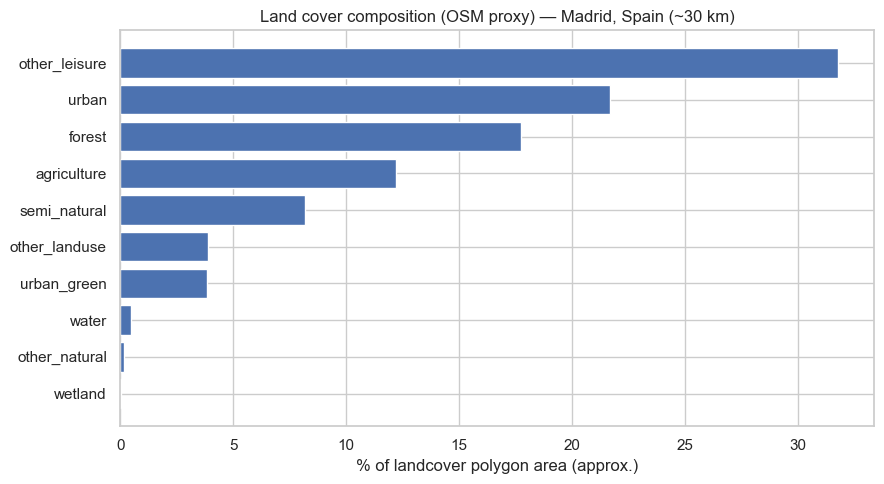

Saved plot: pictures/landcover_composition_madrid_spain_r30km.png


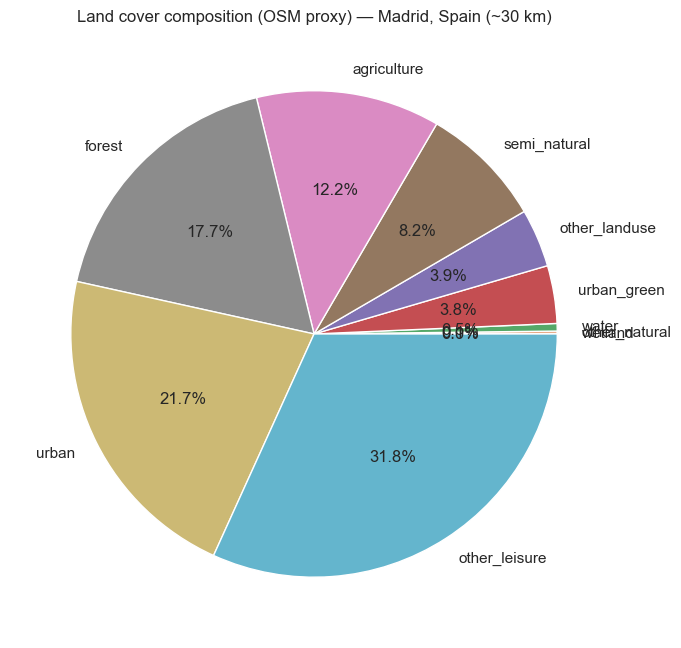

In [21]:
# Compute % area by landcover class and save a chart to pictures/

from pathlib import Path

import matplotlib.pyplot as plt

try:
    # Prefer the in-memory polygons (official LC or OSM proxy) from the previous cell
    lc_gdf = lc_clip.copy()  # type: ignore[name-defined]
except Exception:
    lc_gdf = None

if lc_gdf is None or len(lc_gdf) == 0:
    # Fallback: load the cached OSM landcover GeoJSON if present
    candidates = [
        CACHE_DIR / f"osm_landcover_{safe_city}_r{RADIUS_KM}km.geojson",
        CACHE_DIR / "osm_landcover.geojson",
    ]
    p = next((x for x in candidates if x.exists()), None)
    if p is None:
        raise ValueError("No landcover polygons available. Run the landcover join cell first.")
    lc_gdf = gpd.read_file(p)

if "landcover" not in lc_gdf.columns:
    raise ValueError("Landcover GeoDataFrame must contain a 'landcover' column")

# Ensure CRS
if lc_gdf.crs is None:
    lc_gdf = lc_gdf.set_crs("EPSG:4326")
lc_gdf = lc_gdf.to_crs("EPSG:4326")

# Clip to bbox (avoid expensive global polygons)
lc_gdf = lc_gdf[lc_gdf.intersects(bbox_geom)].copy()

# Compute areas in an equal-area CRS for Europe
bbox_series = gpd.GeoSeries([bbox_geom], crs="EPSG:4326").to_crs("EPSG:3035")
lc_ea = lc_gdf.to_crs("EPSG:3035")

# Optional: clip geometries to bbox to avoid counting outside area
try:
    lc_ea["geometry"] = lc_ea.geometry.intersection(bbox_series.iloc[0])
except Exception:
    pass

lc_ea = lc_ea[~lc_ea.geometry.is_empty].copy()
lc_ea["area_km2"] = lc_ea.geometry.area / 1e6

area = lc_ea.groupby("landcover")["area_km2"].sum().sort_values(ascending=False)
area = area[area > 0]

pct = (area / area.sum() * 100).round(2)
df_cov = (
    pct.rename("pct")
    .to_frame()
    .assign(area_km2=area.round(2))
    .reset_index()
    .sort_values("pct", ascending=True)
)

display(df_cov)

# Plot
plt.figure(figsize=(9, 5))
plt.barh(df_cov["landcover"], df_cov["pct"])
plt.xlabel("% of landcover polygon area (approx.)")
plt.title(f"Land cover composition (OSM proxy) — {CITY} (~{RADIUS_KM} km)")
plt.tight_layout()

out_dir = Path("pictures")
out_dir.mkdir(exist_ok=True)
out_path = out_dir / f"landcover_composition_{safe_city}_r{RADIUS_KM}km.png"
plt.savefig(out_path, dpi=200, facecolor="white")
plt.show()

print("Saved plot:", out_path)

# Optional: pie chart (useful if you have few classes)
plt.figure(figsize=(7, 7))
plt.pie(df_cov["pct"], labels=df_cov["landcover"], autopct="%1.1f%%")
plt.title(f"Land cover composition (OSM proxy) — {CITY} (~{RADIUS_KM} km)")
plt.tight_layout()
plt.savefig(out_dir / f"landcover_composition_{safe_city}_r{RADIUS_KM}km_pie.png", dpi=200, facecolor="white")
plt.show()

### 12.3 Compute distance from each occurrence to the nearest asset (Haversine)

We’ll compute great-circle distance (km) and assign each occurrence to the nearest asset.


In [15]:
def haversine_km(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance (km). Inputs can be numpy arrays."""
    R = 6371.0088
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


# Compute distance from each occurrence to each asset (broadcast)
occ_lat = occ["decimalLatitude"].to_numpy()
occ_lon = occ["decimalLongitude"].to_numpy()

asset_lat = assets["lat"].to_numpy()
asset_lon = assets["lon"].to_numpy()

# dist_matrix shape = (n_occ, n_assets)
dist_matrix = np.vstack(
    [haversine_km(occ_lat, occ_lon, a_lat, a_lon) for a_lat, a_lon in zip(asset_lat, asset_lon)]
).T

nearest_asset_idx = dist_matrix.argmin(axis=1)
occ = occ.copy()

# Use iloc (positional) to avoid index-label mismatches after sorting/filtering assets
occ["nearest_asset_id"] = assets.iloc[nearest_asset_idx]["asset_id"].to_numpy()
occ["nearest_asset_type"] = assets.iloc[nearest_asset_idx]["asset_type"].to_numpy()
occ["distance_km"] = dist_matrix.min(axis=1)

occ[["species", "nearest_asset_id", "distance_km"]].head()

,species,nearest_asset_id,distance_km
0,Sylvia atricapilla,FAC_storage_tank_7,2.764503
0,Sylvia atricapilla,FAC_storage_tank_7,2.764503
1,Cygnus atratus,FAC_storage_tank_7,10.938484
1,Cygnus atratus,FAC_storage_tank_7,10.938484
2,Phoenicurus ochruros,FAC_storage_tank_7,11.511416


### 12.4 Proximity bands (buffers) and biodiversity metrics

We’ll compute, per asset and per distance band:
- number of records
- species richness
- top species

These are useful for “impact zone” style reporting (e.g., within 1 km, 5 km, 20 km).


In [16]:
BANDS_KM = [0, 1, 5, 20, 50]

# Create band labels like 0-1, 1-5, ...
bins = BANDS_KM
labels = [f"{bins[i]}-{bins[i+1]} km" for i in range(len(bins) - 1)]

occ["band"] = pd.cut(occ["distance_km"], bins=bins, labels=labels, right=True, include_lowest=True)

summary = (
    occ.groupby(["nearest_asset_id", "nearest_asset_type", "band"], dropna=False)
    .agg(
        records=("species", "size"),
        species_richness=("species", lambda s: s.nunique(dropna=True)),
        median_uncertainty_m=(
            "coordinateUncertaintyInMeters",
            lambda s: float(pd.to_numeric(s, errors="coerce").median()) if "coordinateUncertaintyInMeters" in occ.columns else np.nan,
        ),
    )
    .reset_index()
)

summary.sort_values(["nearest_asset_id", "band"]).head(20)

,nearest_asset_id,nearest_asset_type,band,records,species_richness,median_uncertainty_m
0,FAC_storage_tank_34,storage_tank,1-5 km,2,2,18.5
1,FAC_storage_tank_34,storage_tank,5-20 km,499,121,8.0
2,FAC_storage_tank_34,storage_tank,20-50 km,298,70,57.0
3,FAC_storage_tank_5,storage_tank,5-20 km,57,40,13.0
4,FAC_storage_tank_5,storage_tank,20-50 km,6,6,49.5
5,FAC_storage_tank_67,storage_tank,1-5 km,4,4,13.5
6,FAC_storage_tank_67,storage_tank,5-20 km,491,115,10.0
7,FAC_storage_tank_7,storage_tank,0-1 km,5,3,5.0
8,FAC_storage_tank_7,storage_tank,1-5 km,90,51,5.0
9,FAC_storage_tank_7,storage_tank,5-20 km,972,182,9.0


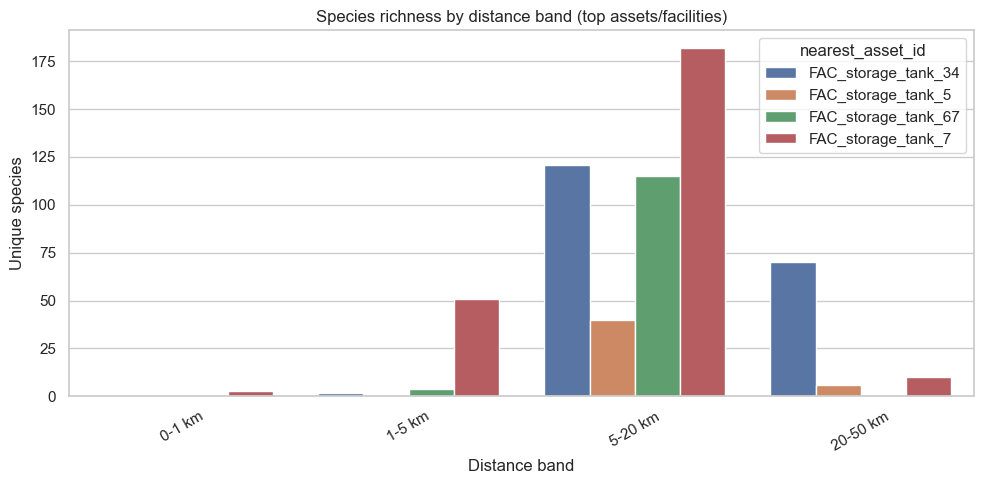

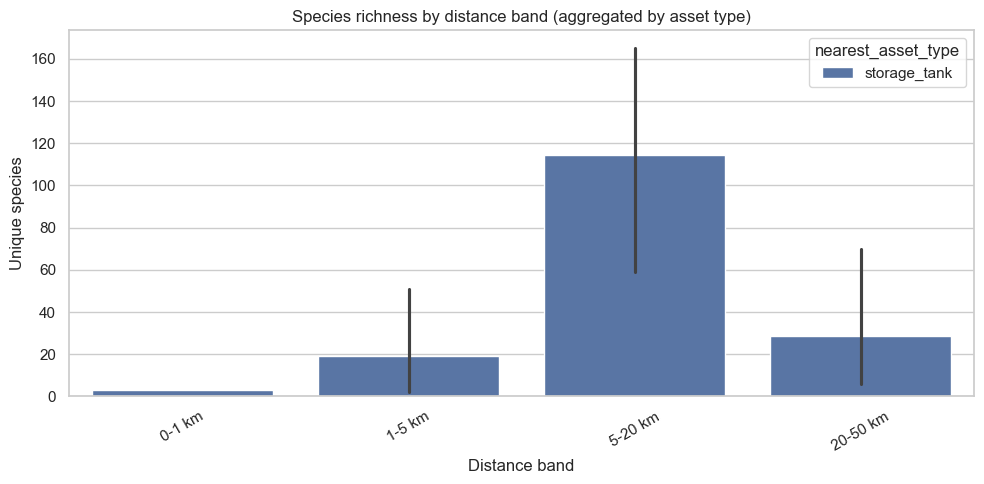

In [17]:
# Plot richness by band for each asset
# If you have many assets/facilities, plotting all IDs as a hue becomes unreadable.
# We plot only the top-N assets by total records.
TOP_ASSETS_TO_PLOT = 8

plot_summary = summary.dropna(subset=["band"]).copy()

top_ids = (
    plot_summary.groupby("nearest_asset_id")["records"].sum().sort_values(ascending=False).head(TOP_ASSETS_TO_PLOT).index
)
plot_summary = plot_summary[plot_summary["nearest_asset_id"].isin(top_ids)]

plt.figure(figsize=(10, 5))
sns.barplot(data=plot_summary, x="band", y="species_richness", hue="nearest_asset_id")
plt.title("Species richness by distance band (top assets/facilities)")
plt.xlabel("Distance band")
plt.ylabel("Unique species")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Alternative: aggregate by asset type (always readable)
plt.figure(figsize=(10, 5))
sns.barplot(data=summary.dropna(subset=["band"]), x="band", y="species_richness", hue="nearest_asset_type")
plt.title("Species richness by distance band (aggregated by asset type)")
plt.xlabel("Distance band")
plt.ylabel("Unique species")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### 12.5 Asset-level “sensitivity score” (simple proxy)

One simple screening proxy is a weighted combination of:
- local **species richness** (within N km)
- local **record density** (within N km)
- (optionally) downweight observations with high coordinate uncertainty

This is **not** an ecological truth metric — it’s a prioritization heuristic.


In [18]:
WITHIN_KM = 20

near = occ[occ["distance_km"] <= WITHIN_KM].copy()

asset_metrics = (
    near.groupby(["nearest_asset_id", "nearest_asset_type"])
    .agg(
        records=("species", "size"),
        richness=("species", lambda s: s.nunique(dropna=True)),
        median_distance_km=("distance_km", "median"),
    )
    .reset_index()
)

# Simple normalization
asset_metrics["records_norm"] = asset_metrics["records"] / asset_metrics["records"].max()
asset_metrics["richness_norm"] = asset_metrics["richness"] / asset_metrics["richness"].max()

# Example score: 70% richness + 30% records
asset_metrics["sensitivity_score"] = 0.7 * asset_metrics["richness_norm"] + 0.3 * asset_metrics["records_norm"]

asset_metrics.sort_values("sensitivity_score", ascending=False)

,nearest_asset_id,nearest_asset_type,records,richness,median_distance_km,records_norm,richness_norm,sensitivity_score
3,FAC_storage_tank_7,storage_tank,1067,205,11.718952,1.000000,1.000000,1.000000
0,FAC_storage_tank_34,storage_tank,501,121,11.272909,0.469541,0.590244,0.554033
2,FAC_storage_tank_67,storage_tank,495,116,9.479404,0.463918,0.565854,0.535273
1,FAC_storage_tank_5,storage_tank,57,40,15.125172,0.053421,0.195122,0.152612


### 12.6 Visualize occurrences around assets

A quick plot to see where occurrences are relative to asset points.


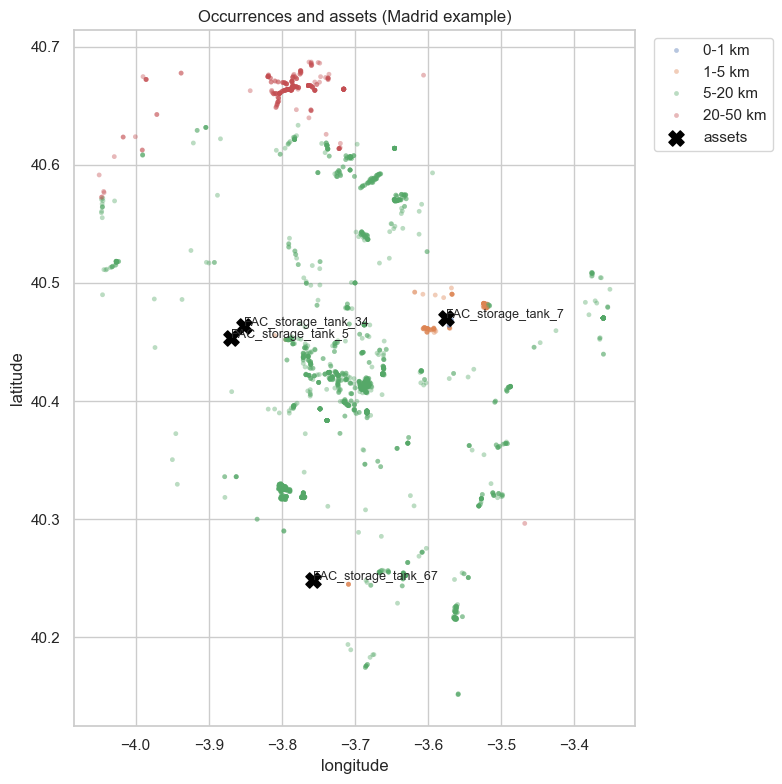

In [19]:
# Color points by distance band (if present)
plot_df = occ.dropna(subset=["decimalLatitude", "decimalLongitude"]).copy()

plt.figure(figsize=(8, 8))
if "band" in plot_df.columns:
    sns.scatterplot(
        data=plot_df,
        x="decimalLongitude",
        y="decimalLatitude",
        hue="band",
        s=12,
        alpha=0.4,
        linewidth=0,
    )
else:
    plt.scatter(plot_df["decimalLongitude"], plot_df["decimalLatitude"], s=10, alpha=0.35)

# Plot assets
plt.scatter(assets["lon"], assets["lat"], s=120, marker="X", color="black", label="assets")
for _, r in assets.iterrows():
    plt.text(r["lon"], r["lat"], r["asset_id"], fontsize=9)

plt.title("Occurrences and assets (Madrid example)")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

### 12.7 Folium basemap: assets + nearby GBIF occurrences

This creates an interactive map (pan/zoom) with:
- asset markers (downloaded from OSM or your manual list)
- GBIF occurrence markers (optionally sampled / clustered)
- optional heatmap layer

Tip: if it feels slow, reduce `MAP_MAX_POINTS`.


In [20]:
MAP_MAX_POINTS = 2000
SHOW_HEATMAP = True

# If your notebook is not "trusted", Jupyter may block the interactive HTML output.
# You can always export to a standalone HTML file (see the bottom of this cell).

# Use the already prepared occurrence table `occ` (after quality filters)
map_points = occ.dropna(subset=["decimalLatitude", "decimalLongitude"]).copy()

if len(map_points) > MAP_MAX_POINTS:
    map_points = map_points.sample(MAP_MAX_POINTS, random_state=42)

m = folium.Map(
    location=[BBOX["center_lat"], BBOX["center_lon"]],
    zoom_start=11,
    tiles="CartoDB positron",
)

# Assets layer
assets_layer = folium.FeatureGroup(name="Assets / facilities", show=True)
for _, a in assets.iterrows():
    label = a.get("name")
    if pd.isna(label) or label is None or str(label).strip() == "":
        label = a["asset_id"]
    folium.Marker(
        location=[a["lat"], a["lon"]],
        tooltip=f"{label} ({a['asset_type']})",
        icon=folium.Icon(color="black", icon="industry", prefix="fa"),
    ).add_to(assets_layer)
assets_layer.add_to(m)

# Occurrences layer (clustered)
occ_layer = folium.FeatureGroup(name="GBIF occurrences (sampled)", show=True)
cluster = MarkerCluster().add_to(occ_layer)

# Simple color by band if present
band_colors = {
    "0-1 km": "red",
    "1-5 km": "orange",
    "5-20 km": "green",
    "20-50 km": "blue",
}

for _, r in map_points.iterrows():
    sp = r.get("species")
    band = r.get("band")
    color = band_colors.get(str(band), "gray")

    folium.CircleMarker(
        location=[r["decimalLatitude"], r["decimalLongitude"]],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.6,
        tooltip=f"{sp} | dist_km={r.get('distance_km', np.nan):.2f} | band={band}",
    ).add_to(cluster)

occ_layer.add_to(m)

# Heatmap layer
if SHOW_HEATMAP:
    heat_layer = folium.FeatureGroup(name="Heatmap", show=False)
    HeatMap(
        data=map_points[["decimalLatitude", "decimalLongitude"]].dropna().values.tolist(),
        radius=18,
        blur=14,
    ).add_to(heat_layer)
    heat_layer.add_to(m)

folium.LayerControl().add_to(m)

# Always export to an HTML file (works even if the notebook is not trusted)
MAP_OUTPUT_PATH = CACHE_DIR / f"oil_screening_map_{safe_city}_r{RADIUS_KM}km.html"
m.save(str(MAP_OUTPUT_PATH))
print("Saved map to:", MAP_OUTPUT_PATH.resolve())

# m

Saved map to: /Users/jakubizewski/Desktop/repos/ie-microsoft-capstone/data/oil_screening_map_madrid_spain_r30km.html
